# 利用CNN实现提取人脸关键点

人脸关键点（也称为人脸特征点）指的是下面的图像中，每个人脸上显示的洋红色的小点。在每个训练和测试图像中，有一个人脸和**68个关键点，其中，人脸的坐标是 (x, y)** 这些关键点标记了人脸的重要区域：眼睛，嘴角，鼻子等。这些关键点与许多应用相关，如人脸滤波、情感识别、姿势识别等。在这里，它们是编号的，你可以看到特定范围的点与该人脸的不同部分相匹配。

![face](images/key_pts_example.png)

这组图像数据是从[YouTube 人脸数据集](https://www.cs.tau.ac.il/~wolf/ytfaces/)中提取的，其中包含YouTube视频中的人物视频。这些视频通过一些处理步骤进行输入，并转换为包含一个人脸和相关关键点的图像帧集。

该人脸关键点数据集由5770张彩色图像组成。所有这些图像都被分成训练数据集与测试数据集。

* 这些图像中有3462张个是训练图像，供模型进行训练。
* 另外2308张是测试图像，用于测试模型的准确性。

我把数据集的读取代码全部封装在`facial_keypoints_dataset.py`中了. 这里我们只需要调用其中的API便可以观察数据集了.

In [1]:
import facial_keypoints_dataset as dataset

数据集的读取使用类完成. 其中训练集和测试集是分开的.

如果磁盘上没有数据集, 则在创建数据集对象的时候会自动下载解压, 默认会把数据下载到`data/`目录下.

In [2]:
train_data = dataset.TrainDataset()

数据集已经存在, 跳过下载解压


数据集对象是由很多样本构成的. 每个样本是一个dict, 有两个元素:

- key='image', 原始人脸图像, ndarray, shape=(w, h,c).
- key='kps', 人脸关键点, ndarray, shape=(68, 2), 其中68表示每张人脸有68个关键点, 2表示坐标.

下面我们查看其中一个样本, 并通过`show_kps()`调用把关键点绘制在人脸图像上.

image shape = (147, 117, 3)
key points shape = (68, 2)


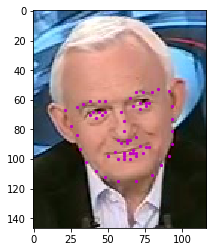

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# 随便选一个样本
sample = train_data[100]

image = sample['image']
kps = sample['kps']

print('image shape =', image.shape)
print('key points shape =', kps.shape)

dataset.show_kps(image, kps)

如果你多测试几组图像, 会发现每张图像的尺寸是不一样的.

所以训练数据还需要进行一些额外的预处理. 这里提供一个`train_transform()`函数专门对样本进行预处理, 它对图像和关键点依次进行如下操作:

- 缩放为固定尺寸
- 随机裁剪
- 转换为灰度图像
- 像素值归一到\[0,1\]之间
- 转换为torch tensor, 注意和numpy不同, torch表示图像是(c, h, w), 这里需要进行转换

我们不需要手动对每个样本调用这个函数, 只需要在创建数据集对象时把这个函数传入即可.

经过这样的处理, 所有图像都会被转换到\[1, 224, 224\]这样的维度. bing'q

In [4]:
# 重新创建一个数据集对象, 这里进行预处理操作
train_data = dataset.TrainDataset(transform=dataset.train_transform)

数据集已经存在, 跳过下载解压


In [6]:
sample = train_data[123]

image = sample['image']
kps = sample['kps']

print('image shape =', image.shape)
print('key points shape =', kps.shape)

image shape = torch.Size([1, 224, 224])
key points shape = torch.Size([68, 2])
